# Extracting Hunting-Titan CBL data from LIS file created by Warrior 8.0

Install TotalDepth from pip on Linux (I use Windows Subsystem for Linux with no problem).

https://github.com/paulross/TotalDepth

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import TotalDepth
from TotalDepth.LIS.core import File, FileIndexer

I created the file using the following settings:

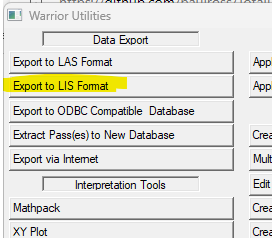

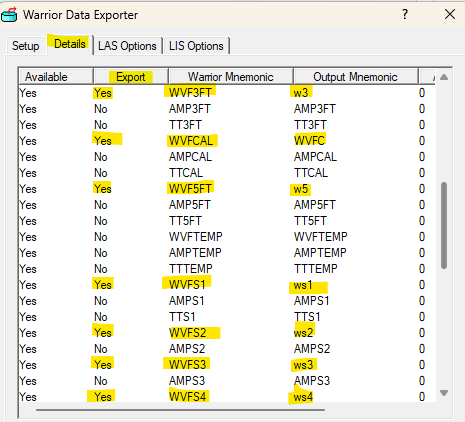

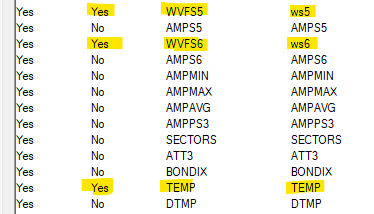

Note that the "output mnemonic" is limited to four characters, despite what is shown. If you don't, the mnemonics will be truncated and although all the data will be written, it'll be impossible to work out which logs are in which location in the frame. Use non-duplicated mnemonics <= 4 characters.

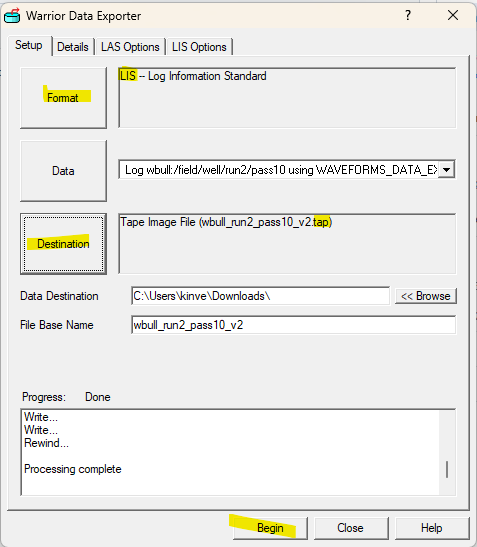

Make sure you hit 'Destination' until the '.tap' file extension appears.

Then "Begin" to export data.

In [2]:
lis_filename = Path("/mnt/c/users/kinve/Downloads/wbull_run2_pass10_v2.tap")

In [3]:
file = File.FileRead(str(lis_filename))
file_idx = FileIndexer.FileIndex(file)
log_passes = [lp for lp in file_idx.genLogPasses()]

log_passes[0].logPass.setFrameSet(file)
sc = [sc for sc in log_passes[0].logPass.genFrameSetScNameUnit()]
data = log_passes[0].logPass.frameSet.frames

``data`` is a plain numpy 2D array - first dimension is depth, second is "frame".

This next code locates each log "horizontally" within the frame dimension.

In [4]:
block_idx = {}

n = 0
for block in log_passes[0].logPass._dfsr.dsbBlocks:
    block_name = block.mnem.strip().decode()
    k = block.values()
    block_idx[block_name] = (n, n + k, k)
    n += k
block_idx

{'TEMP': (0, 1, 1),
 'ws6': (1, 151, 150),
 'ws5': (151, 301, 150),
 'ws4': (301, 451, 150),
 'ws3': (451, 601, 150),
 'ws2': (601, 751, 150),
 'ws1': (751, 901, 150),
 'w5': (901, 1651, 750),
 'WVFC': (1651, 1851, 200),
 'w3': (1851, 2101, 250),
 'DEPT': (2101, 2102, 1)}

Next we split into those logs which are curves (one number per depth) and arrays (multiple numbers per depth):

In [5]:
curve_logs = {name: block_idx[name][0] for name, (i0, i1, k) in block_idx.items() if k == 1}
arr_logs = {name: block_idx[name] for name, (i0, i1, k) in block_idx.items() if k > 1}

In [6]:
curve_logs

{'TEMP': 0, 'DEPT': 2101}

Of these ones, the first and second items of the tuple are the start and end indices in the frame. The third item is the length of each record i.e. "w3" (the 3ft CBL receiver waveform) has 250 samples. It's only through looking at the Warrior Acquisition or Recalculation program that I can see those 250 samples are spaced at 2 us intervals from 0 to 500 us.

Same for "w5", the 5ft receiver - spaced at 2 us intervals from 0 to 1500 us, and same for the radial sectors (ws1 through ws6) - 0 to 300 us (150 samples @ 2 us).

And "WVFC" (WVFCAL - calibration waveform) - it's at 3 us intervals - 0 to 600 us, with 200 samples.

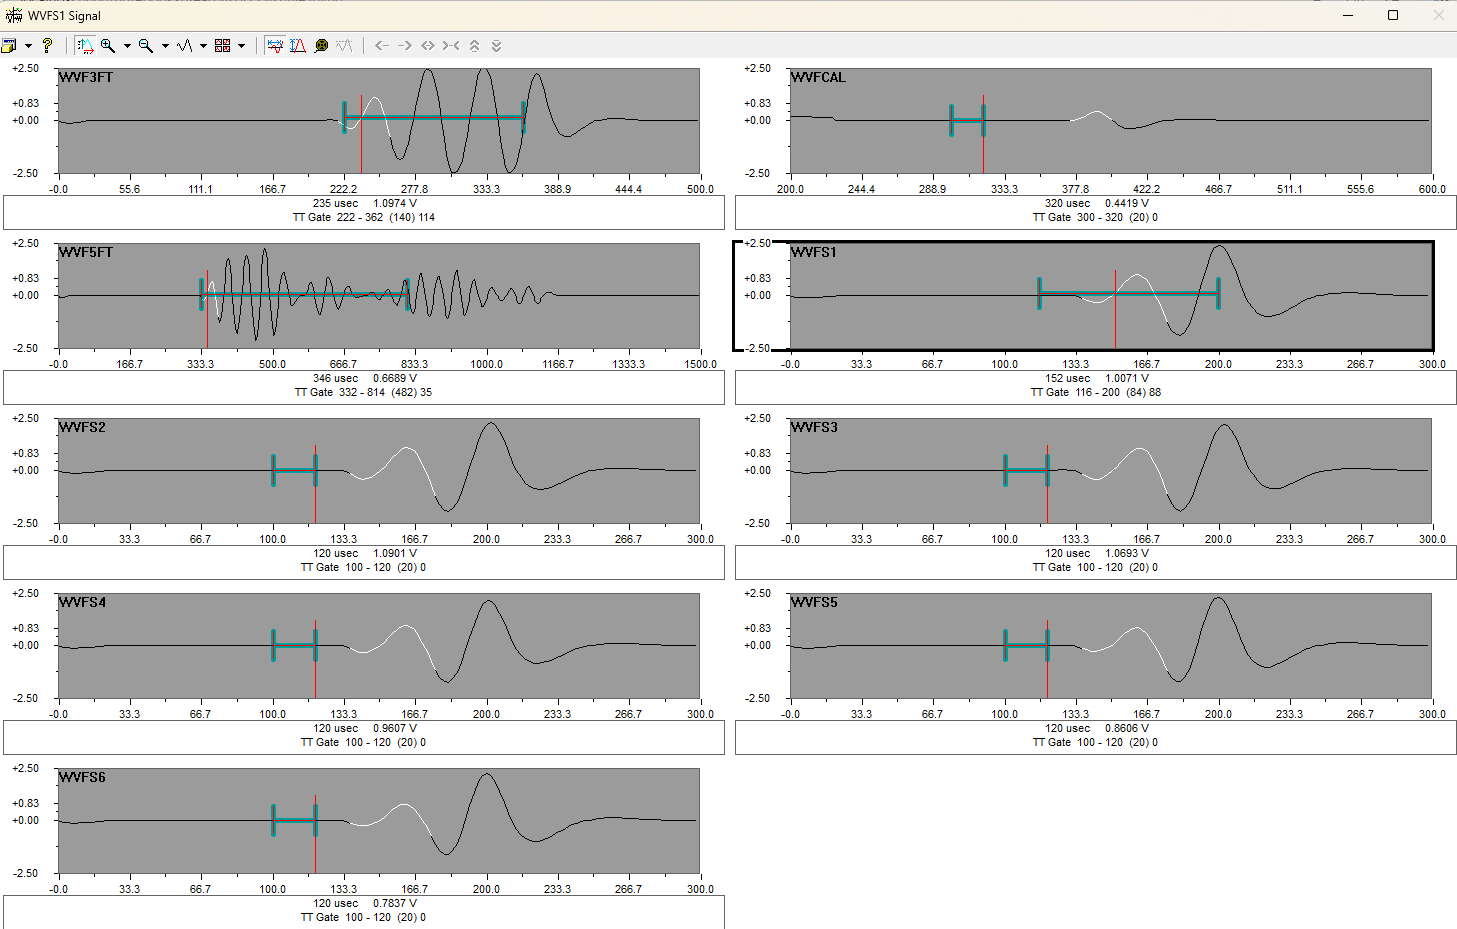

In [7]:
arr_logs

{'ws6': (1, 151, 150),
 'ws5': (151, 301, 150),
 'ws4': (301, 451, 150),
 'ws3': (451, 601, 150),
 'ws2': (601, 751, 150),
 'ws1': (751, 901, 150),
 'w5': (901, 1651, 750),
 'WVFC': (1651, 1851, 200),
 'w3': (1851, 2101, 250)}

In [8]:
curve_logs

{'TEMP': 0, 'DEPT': 2101}

Now we visualise one frame (i.e. one depth record):

Text(0.5, 1.0, 'Frame number #1051')

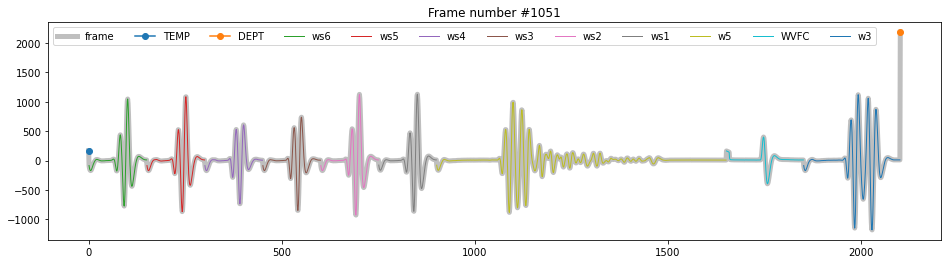

In [9]:
frame_idx = np.arange(data.shape[1])
zi = int(np.floor(len(frame_idx) / 2))
frame = data[zi, :]
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.plot(frame, lw=5, alpha=0.5, label='frame', color='grey')
for name, idx in curve_logs.items():
    ax.plot([idx], [frame[idx]], label=name, marker='o')
for name, (i0, i1, k) in arr_logs.items():
    ax.plot(frame_idx[i0: i1], frame[i0: i1], label=name, lw=1)
ax.legend(fontsize='medium', ncol=12)
ax.set_title(f"Frame number #{zi}")

And now extract all the logs:

(also removing nulls at this point)

In [10]:
null = -999.25
data[data == null] = np.nan

data_extr = {}
for name, idx in curve_logs.items():
    data_extr[name] = data[:, idx]
    
for name, (i0, i1, k) in arr_logs.items():
    data_extr[name] = data[:, i0: i1]

Define the array indices (described above)

In [11]:
indices = {
    'map': {
        'w5': 'w5_idx',
        'w3': 'w3_idx',
        'ws1': 'ws_idx',
        'ws2': 'ws_idx',
        'ws3': 'ws_idx',
        'ws4': 'ws_idx',
        'ws5': 'ws_idx',
        'ws6': 'ws_idx',
        'WVFC': 'wcal_idx',
    },
    'data': {
        'w3_idx': np.linspace(0, 500, 250 + 1),
        'w5_idx': np.linspace(0, 1500, 750 + 1),
        'ws_idx': np.linspace(0, 300, 150 + 1),
        'wcal_idx': np.linspace(0, 600, 200 + 1),
    },
    'units': {
        'w3_idx': 'us',
        'w5_idx': 'us',
        'ws_idx': 'us',
        'wcal_idx': 'us',
    }
}

def get_index_for(name):
    index_name = indices['map'][name]
    return {
        'data': indices['data'][index_name],
        'unit': indices['units'][index_name],
    }


In [12]:
data_extr

{'TEMP': array([         nan,          nan,          nan, ..., 108.44113159,
        108.59486389, 108.76448059]),
 'DEPT': array([2443.5 , 2443.25, 2443.  , ...,    7.5 ,    7.25,    7.  ]),
 'ws6': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [-136., -175., -200., ...,    9.,    9.,    9.],
        [-131., -174., -201., ...,    8.,    9.,    9.],
        [-134., -174., -199., ...,    9.,   10.,   10.]]),
 'ws5': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [-135., -175., -200., ...,    8.,    9.,    9.],
        [-135., -175., -200., ...,    9.,    9.,    9.],
        [-133., -173., -198., ...,    8.,    9.,    9.]]),
 'ws4': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0., 

Example plot

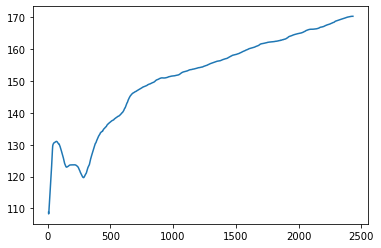

In [13]:
plt.plot(data_extr['DEPT'], data_extr['TEMP'])

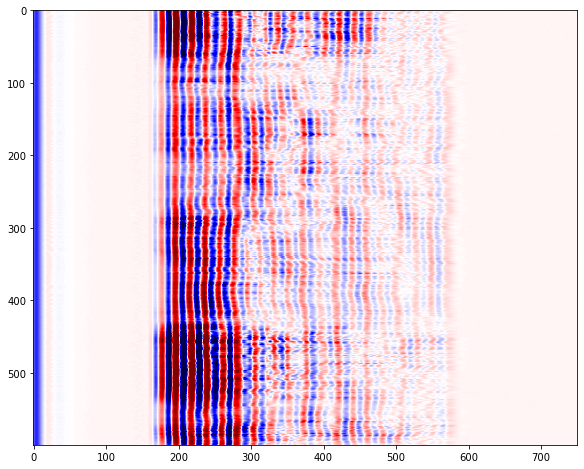

In [14]:
n0 = 1600
n1 = n0 + 600
vampl = 400
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.imshow(
    data_extr['w5'][n0: n1, :], cmap=plt.cm.seismic, vmin=-1 * vampl, vmax=vampl,
)

Write the curves to a LAS file

In [15]:
import lasio
import pandas as pd

index_data = None
filename = f"{lis_filename.stem}_curves.las"

names = [n for n in curve_logs.keys()]

df = pd.DataFrame({name: data_extr[name] for name in names})
df = df.set_index('DEPT')

las = lasio.LASFile()
las.well.WELL = lis_filename.name
las.set_data_from_df(df)

with open(filename, "w") as f:
    las.write(f)

Write the arrays to a WellCAD ASCII format - one file per curve. (WAF)

In [16]:
log_aliases = {
    'w3': 'wvf_3ft',
    'w5': 'wvf_5ft',
    'ws1': 'wvf_18in_s1',
    'ws2': 'wvf_18in_s2',
    'ws3': 'wvf_18in_s3',
    'ws4': 'wvf_18in_s4',
    'ws5': 'wvf_18in_s5',
    'ws6': 'wvf_18in_s6',
    'WVFC': 'wvf_cal'
}

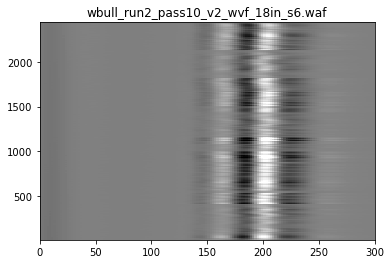

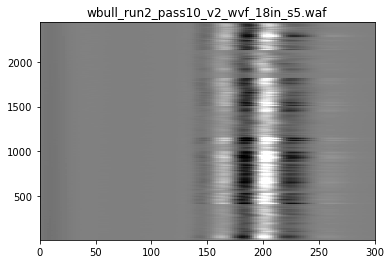

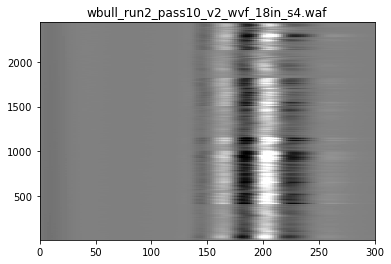

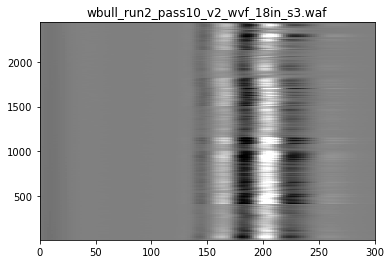

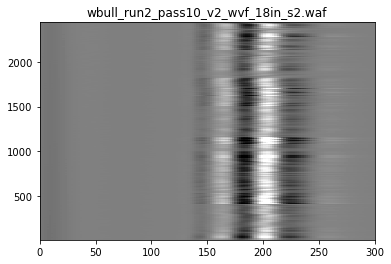

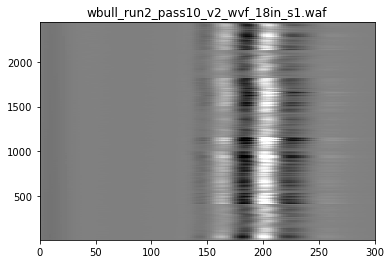

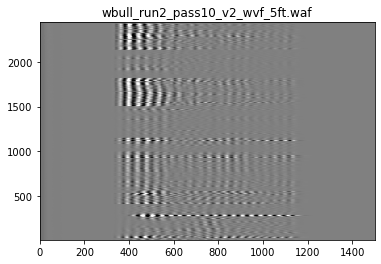

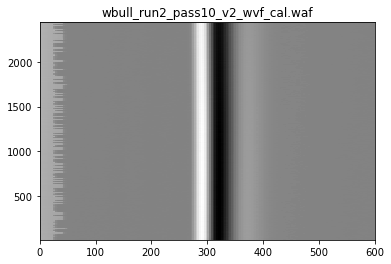

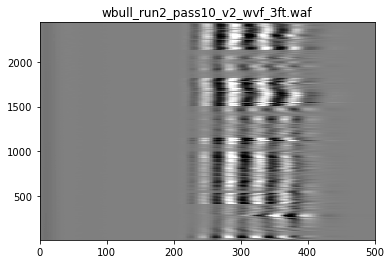

In [17]:
import wellcadformats

for name in arr_logs.keys():
    alias = log_aliases[name]
    
    filename = f"{lis_filename.stem}_{alias}.waf"
    arr_data = data_extr[name]
    arr_idx_data = get_index_for(name)
    
    log = wellcadformats.WAF()
    log.generate(arr_data, depths=data_extr['DEPT'], times=arr_idx_data['data'])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    log.imshow(ax=ax)
    ax.set_title(filename)
    
    with open(filename, 'w') as f:
        log.to_file(f)

And something unnecessary to finish up for another purpose :-)

In [18]:
np.savetxt('example_array_data.txt', data_extr['w5'])